In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from copy import deepcopy
from sklearn.linear_model import LinearRegression, TweedieRegressor, ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
# from dtreeviz.trees import dtreeviz # will be used for tree visualization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from yellowbrick.features import Rank2D, Rank1D
from yellowbrick.features import PCA as ybPCA
from yellowbrick.target import BalancedBinningReference, FeatureCorrelation
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import PredictionError, prediction_error, ResidualsPlot

Label Encoding

In [5]:
# Import and combine label encoded datasets
LE2 = pd.read_pickle("data/5-Final/2-2/LE2.pkl")
LE3 = pd.read_pickle("data/5-Final/3-3/LE3.pkl")
LE4 = pd.read_pickle("data/5-Final/4-0/LE4.pkl")
dataset1 = pd.concat([LE4, LE3, LE2], axis=0)

One-Hot-Encoding

In [3]:
# Import and combine datasets for One-Hot-Encoding
D2 = pd.read_pickle("data/5-Final/2-2/D2.pkl")
D3 = pd.read_pickle("data/5-Final/3-3/D3.pkl")
D4 = pd.read_pickle("data/5-Final/4-0/D4.pkl")
dataset2 = pd.concat([D4, D3, D2], axis=0)

# NOTE One-Hot-encoding PCA data essentially takes continuous data and creates a binary representation, this may not be very useful. 

In [3]:
# TODO Before one-hot-encoding, categorise the data and then do PCA! PCA works best on continuous variables, so label encoding is probably best.

In [6]:
# Labels to drop
dropped_labels = ["SSR_CODE","callsign", "aircraft type", "sensitiveFlight", "exemptionReasonType", "manualExemptionReason", "most pen reg", "flightState" , "company"]
dataset_drop = dataset1.drop(labels=dropped_labels, axis = 1)

# Create the feature and response set 
X = dataset_drop.iloc[:,0:-3]
y = dataset_drop.iloc[:,-3:]

In [7]:
print(f"Shape of X: {X.shape}")

Shape of X: (1184, 8)


In [8]:
#  Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Principal Component Analysis

Perform PCA with the desired threshold of explained variance (e.g., 90%) or specify the number of principal components.

The test set shouldn't be fit to the PCA as this is unseen. It should be purely based from information from the training set.

In [21]:
# pca = PCA(0.90)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [22]:
X_train_pca_Df = pd.DataFrame(data = X_train_pca
             , columns = ['principal component 1','principal component 2'])


In [23]:
X_train_pca_Df.tail()

,principal component 1,principal component 2
883,-235.074751,-25.024055
884,3.254202,117.733562
885,711.149976,28.614732
886,406.234749,47.974800
887,-99.406458,153.887115


Examining the loadings of the principal components will understand their relationships with the original features. The loadings represent the weights assigned to each original feature in the principal component. These weights indicate the contribution of each feature to the corresponding principal component. A large positive or negative loading magnitude indicates a strong influence of the corresponding feature on the principal component.

In [24]:
# Access the loadings (components_)
loadings = pca.components_
feature_names = list(X.columns)
# Assuming your original feature names are stored in a list called "feature_names"
for i, pc in enumerate(loadings):
    print(f"Principal Component {i+1} Loadings:")
    for j, weight in enumerate(pc):
        print(f"Feature {feature_names[j]}: {weight:.3f}")
    print()

Principal Component 1 Loadings:
Feature day: 0.000
Feature origin (ADEP): 0.001
Feature destination (ADES): -0.004
Feature RFL: -0.004
Feature type: -0.000
Feature Planned Time departure: -1.000
Feature originalFlightDataQuality: 0.000
Feature regulationsAffectedByNrOfInstances: -0.000

Principal Component 2 Loadings:
Feature day: 0.001
Feature origin (ADEP): -0.089
Feature destination (ADES): -0.135
Feature RFL: -0.987
Feature type: 0.000
Feature Planned Time departure: 0.004
Feature originalFlightDataQuality: 0.000
Feature regulationsAffectedByNrOfInstances: -0.006



In [25]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.97880297 0.01055091]


Text(0, 0.5, 'PC2')

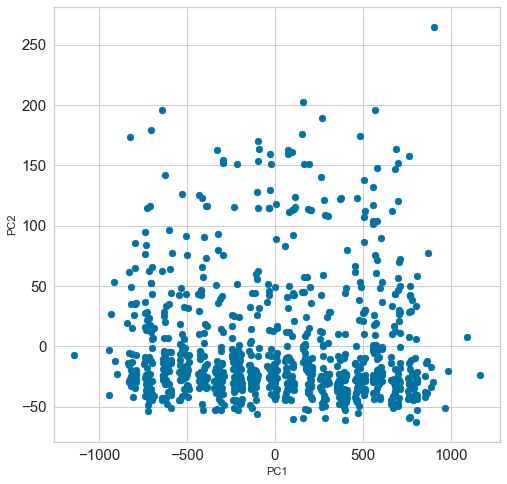

In [26]:
pc1 = X_train_pca[:,0]
pc2 = X_train_pca[:,1]
#Plot principal components
plt.figure(figsize=(8,8))

# colour = ['#ff2121' if y == 1 else '#2176ff' for y in data['y']]
plt.scatter(pc1,pc2)
# plt.ylabel("Glucose",size=20)
# plt.xlabel('Age',size=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
# TODO Needs fixing

pca_df = pd.DataFrame(X_train_pca, columns = ["PC1","PC2"])
# sns.scatterplot(x='PC1', y = 'PC2', data=pca_df)
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.show()

# There is a big cluster near origin of the graph and so those points are all very similar to each other. 

In [88]:
def fit_and_print(p, X_train = X_train_pca, y_train = y_train, X_test = X_test_pca, y_test = y_test):
    """
    This function fits the data to te regressor and carries out prediction
    """
    
    p.fit(X_train, y_train)

    train_preds     = p.predict(X_train)
    cv_score        = cross_val_score(p, X_train, y_train, cv=10)
    test_preds      = p.predict(X_test)
    print(f"CV Score: {np.mean(cv_score)}")
   
    # print('Mean Absolute Error (train):', mean_absolute_error(y_train, train_preds, multioutput='raw_values'))
    (tr_cas, tr_mach, tr_mass) = mean_absolute_error(y_train, train_preds, multioutput='raw_values')
    print(f"Mean Absolute Error (train): {tr_cas}, {tr_mach}, {tr_mass}")

    # print('Mean Absolute Error (test):', mean_absolute_error(y_test, test_preds, multioutput='raw_values'))
    (te_cas, te_mach, te_mass) = mean_absolute_error(y_test, test_preds, multioutput='raw_values')
    print(f"Mean Absolute Error (test): {te_cas}, {te_mach}, {te_mass}")

    # print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_preds, multioutput='raw_values')))
    (RMSE_cas, RMSE_mach, RMSE_mass) = np.sqrt(mean_squared_error(y_test, test_preds, multioutput='raw_values'))
    print(f"Root Mean Squared Error: {RMSE_cas}, {RMSE_mach}, {RMSE_mass}")

    # r2score = p.score(X_test, y_test)
    (r2_cas, r2_mach, r2_mass) = r2_score(y_test, test_preds, multioutput='raw_values')
    print(f"R^2 Score: {r2_cas}, {r2_mach}, {r2_mass}")
    
    # print(p.best_estimator_)
    # print(p.best_params_)

    return tr_cas, tr_mach, tr_mass, te_cas, te_mach, te_mass, RMSE_cas, RMSE_mach, RMSE_mass, r2_cas, r2_mach, r2_mass

## Machine learning

In [89]:
# Linear Regressor

LR = LinearRegression()

In [90]:
reg_results = fit_and_print(LR)

CV Score: 0.03907380169528624
Mean Absolute Error (train): 5.414596164576739, 0.06070235594780239, 7326.559910647476
Mean Absolute Error (test): 5.180743871018337, 0.05863425005897592, 7353.949323694149
Root Mean Squared Error: 7.1631645329039095, 0.07448583247076065, 9943.720528214139
R^2 Score: -0.017751556851578698, 0.09471953601422511, 0.05350658970052946


### Support Vector Regressor

In [91]:
# Support Vector Regressor

svr = MultiOutputRegressor(SVR(kernel='rbf'))
print(svr.get_params().keys())

grid_param_svr = {
    'estimator__C': np.linspace(4600, 4700, 10),
    'estimator__epsilon': np.linspace(20, 40, 10)
}

gs_svr = (GridSearchCV(estimator=svr, 
                      param_grid=grid_param_svr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1,
                      verbose=2,
                      error_score='raise'))



# {'Estimator__estimator__C': 4700.0, 'Estimator__estimator__epsilon': 40.0}

dict_keys(['estimator__C', 'estimator__cache_size', 'estimator__coef0', 'estimator__degree', 'estimator__epsilon', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs'])


In [92]:
svr_results = fit_and_print(gs_svr)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
CV Score: -36103809.25712604
Mean Absolute Error (train): 14.901128686318785, 0.08486150047612345, 7213.749922496549
Mean Absolute Error (test): 15.30458808877052, 0.08198392867619646, 7332.400065067501
Root Mean Squared Error: 16.689918928107172, 0.09838356602375943, 9910.338110170293
R^2 Score: -4.525102968135259, -0.5793592072282607, 0.05985093579919565


### K-nearest neighbors

In [93]:
# K-Nearest Neighbors

knr = KNeighborsRegressor()
print(knr.get_params().keys())
grid_param_knr = {
    'n_neighbors': [13, 14, 15, 20, 35]
}

gs_knr = (GridSearchCV(estimator=knr, 
                      param_grid=grid_param_knr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1,
                      verbose = 2))

# {'Estimator__n_neighbors': 20}

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])


In [94]:
knr_results = fit_and_print(gs_knr)
# {'Estimator__n_neighbors': 2

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CV Score: -37193941.50261076
Mean Absolute Error (train): 5.222269391331856, 0.060241026637122316, 7116.573631192871
Mean Absolute Error (test): 5.107050264335103, 0.05832457540927342, 7447.344154765478
Root Mean Squared Error: 7.2933281113471455, 0.07547013093560627, 10022.605497686778
R^2 Score: -0.055075226875134664, 0.0706356620572475

### Random Forest

In [95]:
#  Random Forest Regressor

rfr = RandomForestRegressor()
print(rfr.get_params().keys())

grid_param_rfr = {
    'n_estimators': [10, 20, 30, 40, 100, 200, 500, 1000]
}

gs_rfr = (GridSearchCV(estimator=rfr, 
                      param_grid=grid_param_rfr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1,
                      verbose = 2))

# {'Estimator__n_estimators': 1000}

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


In [96]:
rfr_results = fit_and_print(gs_rfr)
# {'Estimator__n_estimators': 1000}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CV Score: -41646739.59054159
Mean Absolute Error (train): 2.1048540354984127, 0.024301154217034677, 3044.9977487666124
Mean Absolute Error (test): 5.392786527084506, 0.06119356987330176, 7762.172042568973
Root Mean Squared Error: 7.441484369429552, 0.07771230126469182, 10282.193855214486
R^2 Score: -0.0983760882655551, 0.01459369652951314

### ElasticNet

In [97]:
#  ElasticNet

en = ElasticNet()
print(en.get_params().keys())

grid_param_en = {
    'alpha': [25.4, 24.5, 24.6],
    'l1_ratio': [1]
}

gs_en = (GridSearchCV(estimator=en, 
                      param_grid=grid_param_en, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1,
                      verbose = 2))

# {'Estimator__alpha': 25.4, 'Estimator__l1_ratio': 1}

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])


In [98]:
en_results = fit_and_print(gs_en)
# {'Estimator__alpha': 25.4, 'Estimator__l1_ratio': 1}

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
CV Score: -35945764.868354484
Mean Absolute Error (train): 5.407006045060973, 0.06413104677785902, 7326.547232126243
Mean Absolute Error (test): 5.149800014280606, 0.06106200900106884, 7353.9501984756125
Root Mean Squared Error: 7.131017862741027, 0.07840089145308543, 9943.730416274891
R^2 Score: -0.00863717466373437, -0.00294657178409241

### Lasso

In [99]:
#  Lasso

lasso = Lasso()
print(lasso.get_params().keys())

grid_param_lasso = {
    'alpha': np.linspace(20, 30, 20),
    'fit_intercept': [True]
}

gs_lasso = (GridSearchCV(estimator=lasso, 
                      param_grid=grid_param_lasso, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1,
                      verbose = 2))

# {'Estimator__alpha': 28.421052631578945, 'Estimator__fit_intercept': True}

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])


In [100]:
lasso_results = fit_and_print(gs_lasso)
# {'Estimator__alpha': 28.421052631578945, 'Estimator__fit_intercept': True}

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CV Score: -35945762.74579909
Mean Absolute Error (train): 5.407197910170357, 0.06413104677785902, 7326.549560834234
Mean Absolute Error (test): 5.155122335716613, 0.06106200900106884, 7353.950037801468
Root Mean Squared Error: 7.134301025952264, 0.07840089145308543, 9943.72859821235
R^2 Score: -0.009566153626064056, 

In [101]:
Results = pd.DataFrame(data = [reg_results, rfr_results, en_results, svr_results, knr_results, lasso_results ], 
                    columns= ['tr_cas', 'tr_mach', 'tr_mass', 'te_cas', 'te_mach', 'te_mass', 'RMSE_cas', 'RMSE_mach', 'RMSE_mass', 'R2_cas', 'R2_mach', 'R2_mass'],
                    index = ['Linear Regression', 'RandomForest', 'ElasticNet', 'SVR', 'KNR', 'Lasso' ]
                    )

# Results

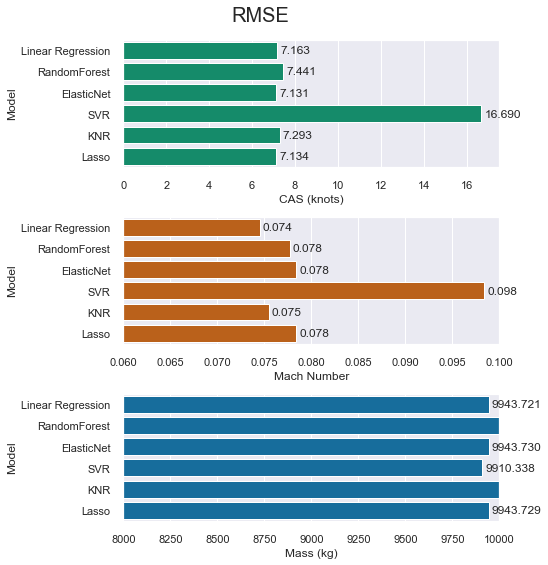

In [102]:
sns.set_theme(style="darkgrid")
sns.set_color_codes("colorblind")
#  constrained_layout = True, 
fig, axes = plt.subplots(3,1, figsize = (7,8)) # Define dimensions of subplots (rows, columns)
fig.suptitle('RMSE', fontsize=20)
sns.barplot(x = 'RMSE_cas', y = Results.index, data = Results, color = 'g', ax = axes[0])
sns.barplot(x = 'RMSE_mach', y = Results.index, data = Results, color = 'r', ax = axes[1])
sns.barplot(x = 'RMSE_mass', y = Results.index, data = Results, color = 'b', ax = axes[2])
plt.tight_layout()
# axes[0].title.set_text('CAS')
axes[0].set_xlabel('CAS (knots)')
axes[0].set_ylabel('Model')
# axes[1].title.set_text('Mach')
axes[1].set_xlabel('Mach Number')
axes[1].set_xlim(0.06,0.10)
axes[1].set_ylabel('Model')
# axes[2].title.set_text('Mass')
axes[2].set_xlabel('Mass (kg)')
axes[2].set_xlim(8000,10000)
axes[2].set_ylabel('Model')

for bars in axes[0].containers:
        axes[0].bar_label(bars, fmt='%.3f', padding=3)
for bars in axes[1].containers:
        axes[1].bar_label(bars, fmt='%.3f', padding=3)
for bars in axes[2].containers:
        axes[2].bar_label(bars, fmt='%.3f', padding=3)
# plt.savefig("results/RMSE.png")

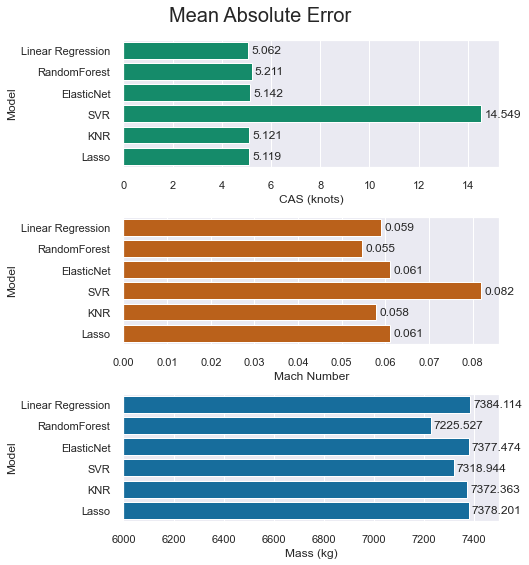

In [64]:

fig, axes = plt.subplots(3,1, figsize = (7,8)) # Define dimensions of subplots (rows, columns)
fig.suptitle('Mean Absolute Error', fontsize=20)
sns.barplot(x = 'te_cas', y = Results.index, data = Results, color = 'g', ax = axes[0])
sns.barplot(x = 'te_mach', y = Results.index, data = Results, color = 'r', ax = axes[1])
sns.barplot(x = 'te_mass', y = Results.index, data = Results, color = 'b', ax = axes[2])

plt.tight_layout()
# axes[0].title.set_text('CAS')
axes[0].set_xlabel('CAS (knots)')
axes[0].set_ylabel('Model')
# axes[1].title.set_text('Mach')
axes[1].set_xlabel('Mach Number')
# axes[1].set_xlim(0.06,0.10)
axes[1].set_ylabel('Model')
# axes[2].title.set_text('Mass')
axes[2].set_xlabel('Mass (kg)')
axes[2].set_xlim(6000,7500)
axes[2].set_ylabel('Model')

for bars in axes[0].containers:
        axes[0].bar_label(bars, fmt='%.3f', padding=3)
for bars in axes[1].containers:
        axes[1].bar_label(bars, fmt='%.3f', padding=3)
for bars in axes[2].containers:
        axes[2].bar_label(bars, fmt='%.3f', padding=3)
# plt.savefig("results/MAE.png")

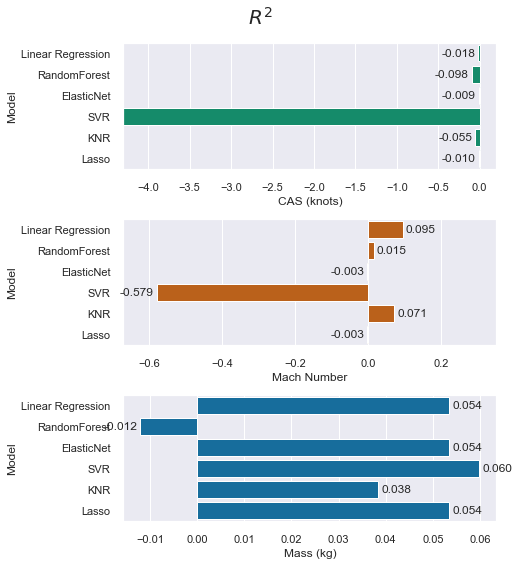

In [103]:
fig, axes = plt.subplots(3,1, figsize = (7,8)) # Define dimensions of subplots (rows, columns)
fig.suptitle('$R^2$', fontsize=20)
sns.barplot(x = 'R2_cas', y = Results.index, data = Results, color = 'g', ax = axes[0])
sns.barplot(x = 'R2_mach', y = Results.index, data = Results, color = 'r', ax = axes[1])
sns.barplot(x = 'R2_mass', y = Results.index, data = Results, color = 'b', ax = axes[2])

plt.tight_layout()

# axes[0].title.set_text('CAS')
axes[0].set_xlabel('CAS (knots)')
axes[0].set_xlim(-4.3,0.2)
axes[0].set_ylabel('Model')
# axes[1].title.set_text('Mach')
axes[1].set_xlabel('Mach Number')
axes[1].set_xlim(-0.67,0.35)
axes[1].set_ylabel('Model')
# axes[2].title.set_text('Mass')
axes[2].set_xlabel('Mass (kg)')
# axes[2].set_xlim(0.125,0.2)
axes[2].set_ylabel('Model')

for bars in axes[0].containers:
        axes[0].bar_label(bars, fmt='%.3f', padding=3)
for bars in axes[1].containers:
        axes[1].bar_label(bars, fmt='%.3f', padding=3)
for bars in axes[2].containers:
        axes[2].bar_label(bars, fmt='%.3f', padding=3)
# plt.savefig("results/R2.png")

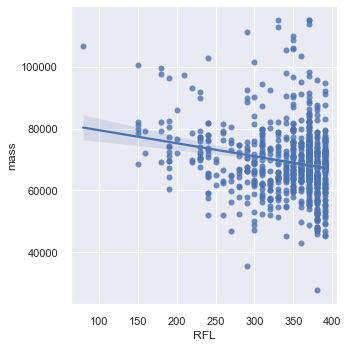

In [104]:
sns.lmplot(x = 'RFL', y = 'mass', data = pd.concat([X_train, y_train], join = 'outer', axis = 1))

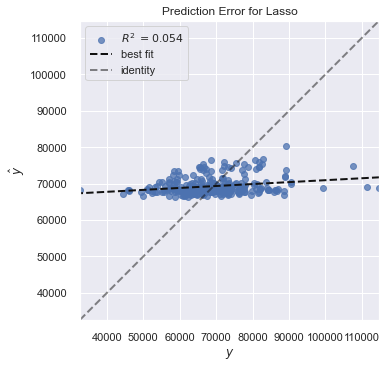

In [105]:
visualise_pred_error = prediction_error(lasso.fit(X_train_pca, y_train['mass']), X_train_pca, y_train['mass'], X_test_pca, y_test['mass'])

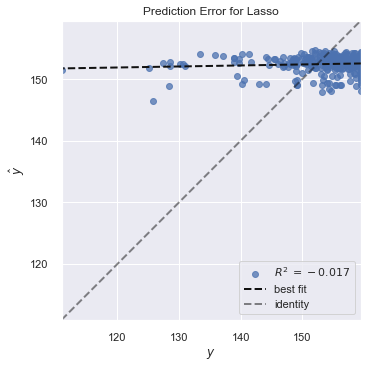

In [106]:
visualise_pred_error = prediction_error(lasso.fit(X_train_pca, y_train['cas']), X_train_pca, y_train['cas'], X_test_pca, y_test['cas'])

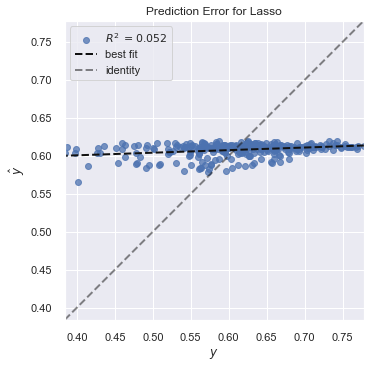

In [107]:
visualise_pred_error = prediction_error(lasso.fit(X_train_pca, y_train['mach']), X_train_pca, y_train['mach'], X_test_pca, y_test['mach'])

0.053504405599920646

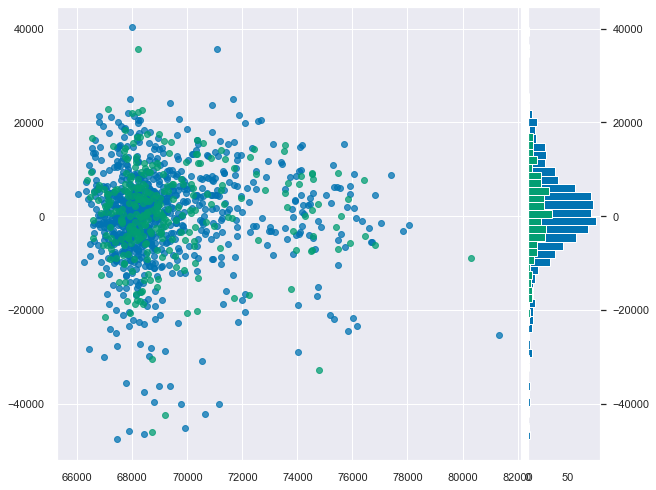

In [108]:
LassoResid = Lasso(alpha = 28.421052631578945)
ResPlot = ResidualsPlot(LassoResid,size=(700, 600))
ResPlot.fit(X_train_pca, y_train['mass'])  # Fit the training data to the visualizer
ResPlot.score(X_test_pca, y_test['mass'])  # Evaluate the model on the test data
# ResPlot.show(outpath="data/Plots/Lasso_ResidualPlot_mass")

0.053506589700528684

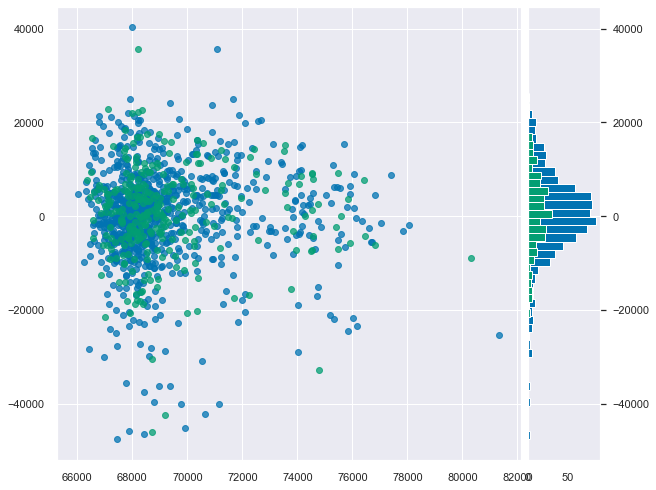

In [109]:
# Residual plot for mass parameter
ResPlot = ResidualsPlot(LinearRegression(),size=(700, 600))
ResPlot.fit(X_train_pca, y_train['mass'])  # Fit the training data to the visualizer
ResPlot.score(X_test_pca, y_test['mass'])  # Evaluate the model on the test data
# ResPlot.show(outpath="data/Plots/LinearReg_ResidualPlot_mass")

0.09471953601422511

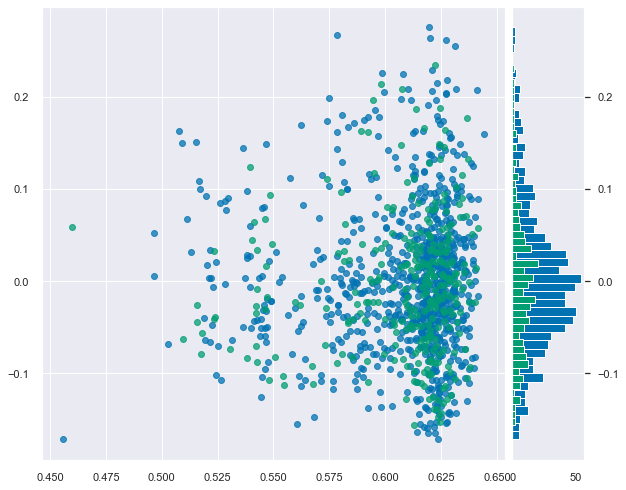

In [110]:
# Residual plot for mach with Linear Regression
ResPlot = ResidualsPlot(LinearRegression(),size=(700, 600))
ResPlot.fit(X_train_pca, y_train['mach'])  # Fit the training data to the visualizer
ResPlot.score(X_test_pca, y_test['mach'])  # Evaluate the model on the test data
# ResPlot.show(outpath="data/Plots/LinearReg_ResidualPlot_mach")

-0.01775155685157892

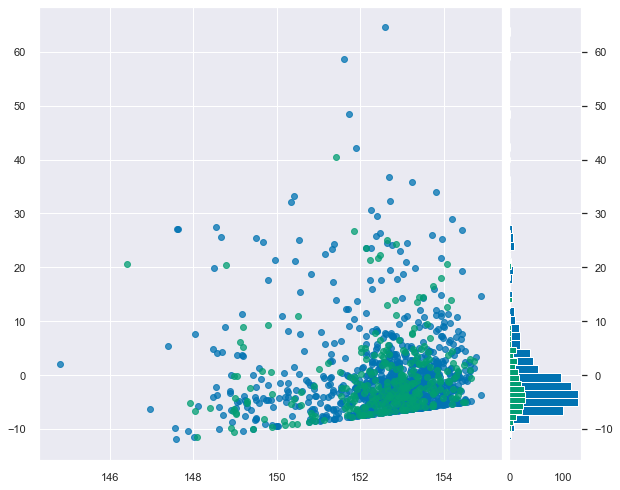

In [111]:
# Residual plot for mass parameter
ResPlot = ResidualsPlot(LinearRegression(),size=(700, 600))
ResPlot.fit(X_train_pca, y_train['cas'])  # Fit the training data to the visualizer
ResPlot.score(X_test_pca, y_test['cas'])  # Evaluate the model on the test data
# ResPlot.show(outpath="data/Plots/LinearReg_ResidualPlot_cas")